# Real-Time Handwritten Digits Recognizer

The automatic recognition of handwritten digits is now a well understood and studied Machine Vision and Machine Learning problem. We will be using MNIST (check out Wikipedia's page on [MNIST](https://en.wikipedia.org/wiki/MNIST_database)) to train our models. From the description on Yann LeCun's [MNIST database of handwriten digits](http://yann.lecun.com/exdb/mnist/):

> The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
> It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.


To learn more, you can also check out Kaggle's [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) page.

In this demo will use MLDB's [classifiers functions](../../../../doc/#builtin/functions/ClassifierApply.md.html) and [REST API](../../../../doc/#builtin/WorkingWithRest.md.html), to create a plug-in to predict the value of handwritten digits. We will also use MLDB's [explain functions](../../../../doc/#builtin/functions/ClassifierExplain.md.html) to visually represent the predictive "value or importance" of each pixel in our final predictions.

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](../../../../doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](../../../../doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [718]:
from pymldb import Connection
mldb = Connection()

... And other Python librairies

In [719]:
import random
import numpy as np
from pandas import DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display
from ipywidgets import widgets

## Loading the data

A pickled version of the dataset is available on the deeplearning.net website http://deeplearning.net/tutorial/gettingstarted.html.

The dataset has been unpickled and saved in a public Amazon's S3 cloud storage. Check out MLDB's [Protocol Handlers](../../../../doc/#builtin/Url.md.html) for Files and URLS.

In [720]:
data_url_mnist = 'http://public.mldb.ai.s3.amazonaws.com/datasets/digits_data.csv.gz'

print mldb.put('/v1/procedures/import_digits_mnist', {
    "type":"import.text",
    "params": {
        "dataFileUrl": data_url_mnist,
        "outputDataset": "digits_mnist",
        "select": "{* EXCLUDING(\"785\")} AS *, \"785\" AS label",
        "runOnCreation": True,
    }
})

<Response [201]>


## Let's explore the data

See the [Query API](../../../../doc/#builtin/sql/QueryAPI.md.html) documentation for more details on SQL queries.

In [721]:
data_count = mldb.query("""
    SELECT 
        avg(horizontal_count({* EXCLUDING(label)})),
        vertical_count({label})
    FROM digits_mnist 
""")

number_of_features = data_count.values[0][0]
number_of_examples = data_count.values[0][1]

print "Total features: %d" %number_of_features
print "Total test examples: %d" %number_of_examples

Total features: 784
Total test examples: 60000


Each example is a row made up of 784 pixels or features. By reshaping the 1D data into a 2D representation, we can visualize the data a little better. At each refresh, we get a randomly selecting rows for each label:

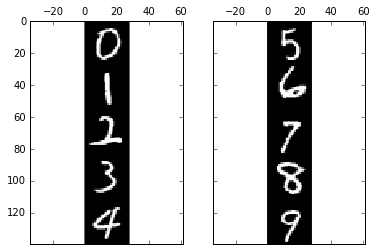

In [722]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

no_test_img = mldb.query("SELECT count({label}) FROM digits_mnist WHERE rowHash() % 5 = 0").values[0][0]

x_array1 = []
x_array2 = []
x_data = []
sq = int(np.sqrt(number_of_features))

for label in labels:
    offset = random.randint(0, int(no_test_img/len(labels)))
    x_data = mldb.query("""
        SELECT * EXCLUDING(label) 
        FROM digits_mnist 
        WHERE label = %d and rowHash() %% 5 = 0
        LIMIT 1
        OFFSET %d
    """ %(label, offset))
    
    if label < 5:
        x_array1.extend(x_data.as_matrix().reshape(sq, sq))
    if label >= 5:
        x_array2.extend(x_data.as_matrix().reshape(sq, sq))    

f, (fig1, fig2) = plt.subplots(1, 2, sharey=True)
fig1.matshow(x_array1)
fig2.matshow(x_array2)
plt.show()

## Training a classifier
We will create a [Procedure](../../../../doc/#builtin/procedures/Procedures.md.html) of type [`classifier.experiment`](../../../../doc/#builtin/procedures/ExperimentProcedure.md.html) to train and test our model. The `configuration` parameter defines a Random Forest algorithm.

In [723]:
conf_algo =  {
    "bbdt_d5": {
        "type": "bagging",
        "verbosity": 3,
        "weak_learner": {
            "type": "boosting",
            "verbosity": 3,
            "weak_learner": {
                "type": "decision_tree",
                "max_depth": 7,
                "verbosity": 0,
                "update_alg": "gentle",
                "random_feature_propn": 0.3
            },
            "min_iter": 5,
            "max_iter": 30
        },
        "num_bags": 5
    }
}

conf_class = {
    "type": "classifier.experiment",
    "params": {
        "experimentName": "mnist_model",
        "mode": "categorical",
        "inputData" : """
            SELECT 
                {* EXCLUDING(label*)} AS features, 
                label AS label
            FROM digits_mnist
        """,
        "datasetFolds": [
            {
                "trainingWhere": "rowHash() % 5 != 0", #80% of total data
                "testingWhere": "rowHash() % 5 = 0"    #20% of total data
            }
        ],
        "algorithm": "bbdt_d5",
        "configuration": conf_algo,
        "modelFileUrlPattern": "file://models/mnist_model.cls",
        "keepArtifacts": True,
        "outputAccuracyDataset": True,   
        "runOnCreation": True,
        "evalTrain": True
    }
}

results = mldb.put("/v1/procedures/mnist_model", conf_class)

In [724]:
accuracy = results.json()['status']['firstRun']['status']['aggregatedTest']['weightedStatistics']['accuracy']['mean']
print "\nModel classification accuracy on test set = %0.4f\n" % accuracy


Model classification accuracy on test set = 0.9717



We are now going to construct the confusion matrix from results on the test set using the [`pivot` aggregate function](../../../../doc/#builtin/sql/ValueExpression.md.html). You can learn more about confusion matrices [here](https://en.wikipedia.org/wiki/Confusion_matrix).

             0     1     2     3     4     5     6     7     8     9
_rowName                                                            
[0]       1207     0     4     1     1     3     5     1     2     5
[1]          0  1351     2     1     2     0     1     5     2     0
[2]          2     9  1163    21     1     2     2     6     8     0
[3]          1     0     3  1184     0    12     0     3     7    10
[4]          1     2     9     1  1093     2     2     6     5     9
[5]          0     0     0    10     0  1065     9     0    10     4
[6]          4     2     5     0     2     5  1184     0     3     2
[7]          0     0     8     8     4     0     0  1289     1    10
[8]          9     3     6     9     0     6     3     1  1118     8
[9]          1     0     2     8    21     6     0     7     9  1173


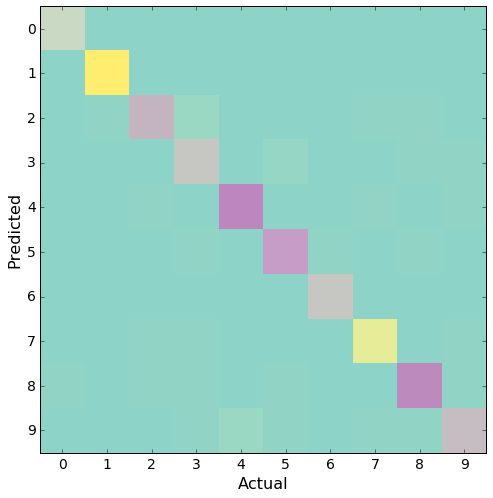

In [725]:
confusionMatrix = mldb.query("""
    SELECT pivot(actual, num) AS *
    FROM (
        SELECT label AS actual, maxLabel AS predicted, count(*) AS num
        FROM mnist_model_results_0
        GROUP BY label, maxLabel
    )
    GROUP BY predicted
""")

df = confusionMatrix.reindex_axis(sorted(confusionMatrix.columns), axis=1).fillna(0)
print df

import matplotlib
fig = plt.figure(figsize=(8, 8))
plt.imshow(df, interpolation='nearest', cmap='Set3')
plt.yticks(np.arange(0, 10, 1), fontsize=14)
plt.ylabel("Predicted", fontsize=16)
plt.xticks(np.arange(0, 10, 1), fontsize=14)
plt.xlabel("Actual", fontsize=16)

The model seems to be doing a pretty good job at classfication as seen with the confusion matrix above. In a small percentage of cases, the model seems to think that a '4' is a '9' and that a '3' is a '2'. The two sets of digits are similar in the concentration of pixels, so this makes some sense.

## How does the model make its predictions? The 'explain' function provides each pixel's weight on the final outcome.

Let's create a function of type [`classifier.explain`](../../../../doc/#builtin/functions/ClassifierExplain.md.html) to help us understand what's happening here.

In [726]:
mldb.put('/v1/functions/mnist_explainer', { 
    "id": "mnist_explainer", 
    "type": "classifier.explain",
    "params": { "modelFileUrl": "file://models/mnist_model.cls" }
})

<Response [201]>

## We automatically get a REST API to test our model with individual digits

The procedure above created for us a [Function](../../../../doc/#builtin/functions/Functions.md.html) of type [`classifier`](../../../../doc/#builtin/functions/ClassifierApply.md.html). We will be using two functions:
* The scorer function: Scores aren't probabilities, but they can be used to create binary classifiers by applying a cutoff threshold. MLDB's `classifier.experiment` procedure that we have seen previously outputs a score for each digit (even the wrong ones).
* The explain function: The explain function is called and outputs the weight of each pixels towards the final prediction. Negative values lower the probability while positive values increase the probability.

Note that the digits are from the test set - we used 80% of the data for training and 20% for testing.

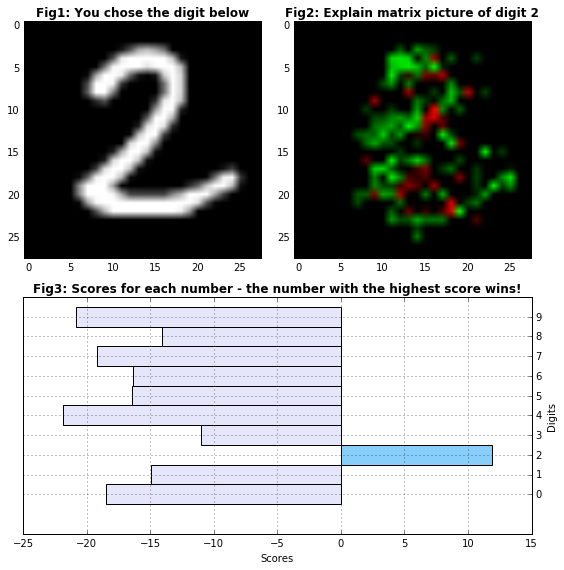

In [727]:
def rgb_explain(x):
    scale = 5
    explain = [[0, 0, 0]] * number_of_features # [R,G,B] for color pic
    number_explain = len(x)
    
    for j, col in enumerate(x.columns.values):
        try:
            index = int(col)
            val = x.values[0][j] * scale
            if (val >= 0.2):
                explain[index] = [0, val, 0] # make it green
            elif (val <= -0.2):
                explain[index] = [- val, 0, 0] # make it red
        except:
            pass
    
    return np.array(explain).reshape(sq, sq, 3)

@widgets.interact
def test_img_plot(digit = [0,9] ,offset=[0,1000]):
    
    data = mldb.query("""
        SELECT 
            * EXCLUDING(label),
            mnist_model_scorer_0({ features: {* EXCLUDING(label*)} })[scores] AS score
        FROM digits_mnist
        WHERE label = %(digit)d AND rowHash() %% 5 = 0
        LIMIT 1
        OFFSET %(offset)d
    """ % {"digit": digit, "offset": offset})
    
    data_array = data.as_matrix()
    
    rand_test_img = data_array[0][:-10].reshape(sq, sq)
    scores = data_array[0][-10:]
    
    explain_data = mldb.query("""
        SELECT 
            mnist_explainer({
                label: %(digit)d,
                features: {* EXCLUDING(label)}
            })[explanation] AS *
        FROM digits_mnist 
        WHERE label = %(digit)d AND rowHash() %% 5 = 0
        LIMIT 1
        OFFSET %(offset)d
    """ % {"digit": digit, "offset": offset})
        
    explain_img = rgb_explain(explain_data)
    
    fig = plt.figure(figsize=(8, 8))
    
    # plot digit image
    ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan = 2)
    ax1.imshow(rand_test_img)
    ax1.set_title("Fig1: You chose the digit below", fontsize=12, fontweight='bold')
    
    # plot explain matrix
    ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan = 2)
    ax2.imshow(explain_img)
    ax2.set_title("Fig2: Explain matrix picture of digit %d" %digit, fontsize=12, fontweight='bold')
    
    # plot scores
    ax3 = plt.subplot2grid((4, 4), (2, 0), colspan=4, rowspan = 2)
    greater_than_zero = scores >= 0
    lesser_than_zero = scores < 0
    ax3.barh(np.arange(len(scores))[greater_than_zero]-0.5, scores[greater_than_zero], color='#87CEFA', height=1)
    ax3.barh(np.arange(len(scores))[lesser_than_zero]-0.5, scores[lesser_than_zero], color='#E6E6FA', height=1)
    ax3.grid()
    ax3.yaxis.set_ticks(np.arange(0, 10, 1))
    ax3.yaxis.set_ticks_position('right')
    ax3.set_title("Fig3: Scores for each number - the number with the highest score wins!", fontsize=12, fontweight='bold')
    ax3.set_ylabel("Digits")
    ax3.yaxis.set_label_position('right')
    ax3.set_xlabel("Scores")
    
    plt.tight_layout()
    plt.show()
    

In the representation of the explain matrix (figure 3), the green pixels help increase the score while the red pixels help decrease the score of the chosen digit. The explain matrix will tell us something about the pixels deemed most important. For example, if nothing was drawn in the top left corner of the picture during training, no information will be provided on the top left set of pixels in the explain matrix. During training, if a pixel is not part of the classification rules (i.e. not on any leaf), that pixel will not show up in the explain matrix.

# Making a simple web app using MLDB plug-in functionality

With an MLDB plugin, we can extend functionality that we have seen so far. For more information, check out the on [plugins](../../../../doc/#builtin/plugins/Plugins.md.html)

In [728]:
mldb.put("/v1/plugins/my_pluginster", {
    "type": "python",
    "params": {
        "address": "file:///mldb_data/do_you_knowwwwwzer_buster"
    }
})

<Response [201]>

Now you can browse to [the plugin UI](../../../../v1/plugins/my_pluginster/routes/static/index.html).

NOTE: this only works if you're running this Notebook live, not if you're looking at a static copy on http://docs.mldb.ai. See the documentation for [Running MLDB](../../../../doc/#builtin/Running.md.html).

## Where to next?

If you are interested in building your own custom image manipulation algorithms, you can click [here](../../../../ipy/notebooks/_demos/Convolutions%20using%20SQL%20and%20javascript.ipynb) to jump to the Convolution Demo. Otherwise, check out the other [Tutorials and Demos](../../../../doc/#builtin/Demos.md.html).